Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Compliance Evaluations by Congressional District

This notebook examines ECHO data using ICIS_FEC_EPA_INSPECTIONS.
The fields in this table are:
<ol>
    <li>REGISTRY_ID, </li>
    <li>STATUTE_CODE, </li>
    <li>ACTUAL_BEGIN_DATE</li>

The REGISTRY_ID identifier is linked to the ECHO_EXPORTER table's field of the same name.

The STATUTE_CODE of interest for this notebook is 'CAA'.
    
A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


In [2]:
#data_location = "https://github.com/edgi-govdata-archiving/echo-data/blob/master/ECHO_EXPORTER.csv?raw=true" # Where the ECHO data is saved
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where  e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and f.ZIP_CODE=%s" %(my_zip)
#sql='show tables'  
#sql= 'show columns from `ECHO_EXPORTER` '

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27


In [3]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
echo_data.set_index( "REGISTRY_ID", inplace=True)

# local_data_location = "../../ICIS_Air_Violation/ECHO_EXPORTER-Air.csv"
# echo_data = pd.read_csv(local_data_location,encoding='iso-8859-1',header = 0)


Run this next cell, select a state, and then run the following cell.

In [4]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [5]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12702 ICIS facilities in LA tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.

In [6]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 18), value=1)

Run this next cell after choosing a congressional district from the dropdown list.

In [7]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 609 ICIS facilities in LA district 2 tracked in the ECHO database.


Next look up the compliance monitoring history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [8]:
# sql = "select PGM_SYS_ID, STATE_EPA_FLAG, AGENCY_TYPE_DESC, COMP_MONITOR_DESC, ACTUAL_END_DATE from `ICIS-AIR_FCES_PCES` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='

sql = "select REGISTRY_ID, ACTUAL_END_DATE from `ICIS_FEC_EPA_INSPECTIONS` where STATUTE_CODE = 'CAA'"
# sql = "show columns from `ICIS_FEC_EPA_INSPECTIONS`"
# sql = "show tables from slim_echoepa_a"
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select REGISTRY_ID, ACTUAL_END_DATE from `ICIS_FEC_EPA_INSPECTIONS` where STATUTE_CODE = 'CAA'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20ACTUAL_END_DATE%20from%20%60ICIS_FEC_EPA_INSPECTIONS%60%20where%20STATUTE_CODE%20%3D%20%27CAA%27


In [9]:
icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "REGISTRY_ID", inplace=True)

In [14]:
icis_data

,ACTUAL_END_DATE
REGISTRY_ID,
1.100004e+11,04/11/2014
1.100123e+11,04/22/2014
1.100589e+11,03/27/2014
1.100589e+11,12/06/2013
1.100449e+11,11/02/2013
...,...
1.100004e+11,08/20/2008
1.100069e+11,02/12/2008
1.100098e+11,10/24/2014


In [19]:
# Find the facility that matches the inspection, by REGISTRY_ID.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # breakpoint()
    fac_id = fac.Index
    try:
        air_inspections = icis_data.loc[ fac_id ].copy()
        # breakpoint()
        n = air_inspections.shape[0]
        fac_list = [fac.Index] * n
        air_inspections['facility'] = fac_list
        frames = [my_cd_icis, air_inspections]
        my_cd_icis = pd.concat( frames, ignore_index=False )
    except KeyError:
        # The facility wasn't found in the ICIS_FEC_EPA_INSPECTIONS data.
        no_data_ids.append( fac.Index )
    
my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

Map the facilities that have had these compliance evaluations.

In [20]:

print( "Facilities without inspections: " + str( len( no_data_ids )))
print( "Facilities with inspections: " + str( len( my_cd_icis )))
my_cd_icis

Facilities without inspections: 559
Facilities with inspections: 104


,0,ACTUAL_END_DATE,facility
ACTUAL_END_DATE,01/13/2011,NaN,NaN
facility,[110001267502.0],NaN,NaN
ACTUAL_END_DATE,01/12/2011,NaN,NaN
facility,[110000548943.0],NaN,NaN
ACTUAL_END_DATE,06/12/2012,NaN,NaN
...,...,...,...
facility,[110041624472.0],NaN,NaN
ACTUAL_END_DATE,05/21/2009,NaN,NaN
facility,[110000547953.0],NaN,NaN
ACTUAL_END_DATE,07/29/2008,NaN,NaN


In [21]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]

In [22]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [24]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()
cd_array


array(['ALBEMARLE CORP - PROCESS DEVELOPMENT CENTER', 'BASF CORP',
       'CARROLLTON WATER PURIFICATION PLANT',
       'CENTRAL WASTEWATER TREATMENT PLANT',
       'DELTA TERMINAL SERVICES, LLC',
       'EXXONMOBIL CHEMICAL CO - BATON ROUGE PLASTICS PLANT',
       'HARCROS CHEMICALS INC', 'IMTT-GEISMAR - GEISMAR LOGISTICS CENTER',
       'INTERNATIONAL MATEX TANK TERMINAL (IMTT) - GRETNA FACILITY',
       'KOCH NITROGEN CO LLC-TAFT TERMINAL', 'MEXICHEM FLUOR',
       'NALCO COMPANY LLC- GARYVILLE FACILITY',
       'PIONEER AMERICAS LLC DBA OLIN CHLOR ALKALI PRODUCTS - ST GABRIEL FACILITY',
       'SOUTHERN UNIVERSITY A&M COLLEGE - BATON ROUGE CAMPUS'],
      dtype=object)

In [25]:
w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('ALBEMARLE CORP - PROCESS DEVELOPMENT CENTER', 'BASF CORP', 'C…

Run this next cell after choosing a facility.

In [26]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
my_inspections = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]
my_inspections


,0,ACTUAL_END_DATE,facility
1.100225e+11,NaN,02/12/2013,1.100225e+11
1.100225e+11,NaN,05/20/2009,1.100225e+11


## Plot the number of violations by year, using the entire state.
For this we can use the statewide numbers, as they will be small for individual districts.

In [27]:
icis_data

,ACTUAL_END_DATE
REGISTRY_ID,
1.100004e+11,04/11/2014
1.100123e+11,04/22/2014
1.100589e+11,03/27/2014
1.100589e+11,12/06/2013
1.100449e+11,11/02/2013
...,...
1.100004e+11,08/20/2008
1.100069e+11,02/12/2008
1.100098e+11,10/24/2014


In [28]:
import datetime

format_str = '%m/%d/%Y' # The format
nan_count = 0
year_col = []
for day in icis_data['ACTUAL_END_DATE']:
    try:
        # breakpoint()
        viol_year = datetime.datetime.strptime(day, format_str).year
        year_col.append( viol_year )
    except:
        nan_count += 1
        year_col.append(  np.NaN )
icis_data['ACTUAL_END_DATE'] = year_col
icis_data

,ACTUAL_END_DATE
REGISTRY_ID,
1.100004e+11,2014.0
1.100123e+11,2014.0
1.100589e+11,2014.0
1.100589e+11,2013.0
1.100449e+11,2013.0
...,...
1.100004e+11,2008.0
1.100069e+11,2008.0
1.100098e+11,2014.0


                 ACTUAL_END_DATE
ACTUAL_END_DATE                 
1998.0                         1
1999.0                         2
2000.0                         6
2001.0                        35
2002.0                       207
2003.0                       746
2004.0                      1670
2005.0                      1674
2006.0                      1465
2007.0                      1718
2008.0                      1586
2009.0                      1630
2010.0                      1369
2011.0                      1264
2012.0                      1297
2013.0                       833
2014.0                       904
2015.0                       760
2016.0                       736
2017.0                       638
2018.0                       636
2019.0                       518
2020.0                       120


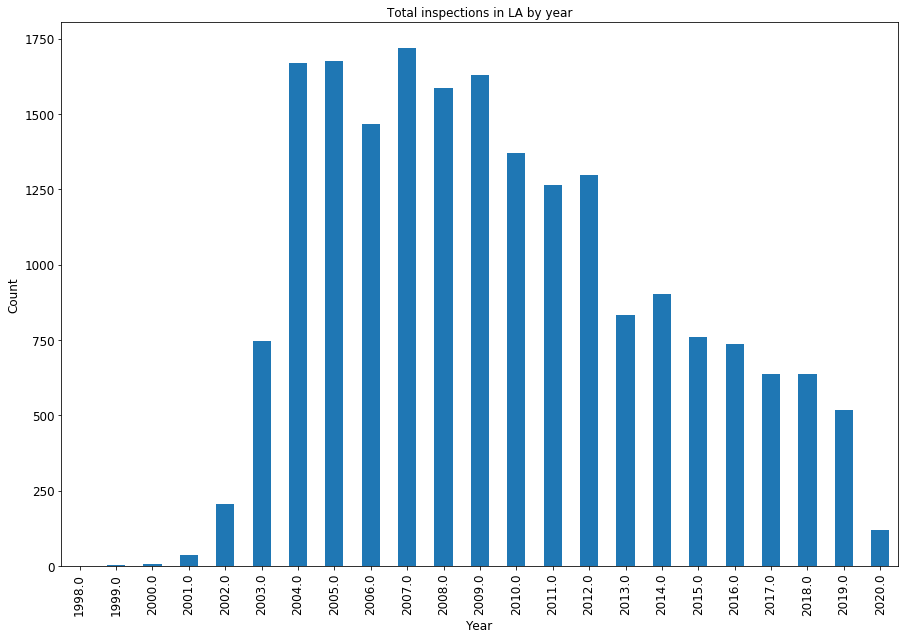

In [29]:
year_groups = icis_data.groupby("ACTUAL_END_DATE")[["ACTUAL_END_DATE"]]
counted_years = year_groups.count()

# Print how many values are present 
print(counted_years)
chart_title = "Total inspections in " + my_state + " by year"

ax = counted_years[['ACTUAL_END_DATE']].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

